In [114]:
# generic imports
import numpy as np
import pandas as pd
import cvxpy as cp
import math

In [115]:
# initial time step and final time under control
# 100,000 seconds is a little over a day
timeStep = 100
numSteps = 1000

# inital x sattelite (x,y,z,dx,dy,dz)
x_0 = np.array([0,1,0,0,0,0]).reshape((6,1))


# find the specific velocity pebetuation that we want for a given time step.
def delt(u,i,delta):
    return np.array([[0],[0],[0],[u[i][0]*delta],[u[i][1]*delta],[u[i][2]*delta]])

# phi matrix given time and beginning time.
def phi(t_i,t_0, n=(2*np.pi) / 86400):
    t = t_i - t_0
    return np.array([[4 - 3*math.cos(n*t), 0, 0, (1/n) * math.sin(n*t), (2/n) * (1 - math.cos(n*t)),0],
                 [6*(math.sin(n*t)-n*t),1, 0, -1*(2/n)*( 1 - math.cos(n*t)), (1/n)*(4*math.sin(n*t) - 3*n*t),0],
                 [0,0,math.cos(n*t),0,0,(1/n)*math.sin(n*t)],
                 [3*n*math.sin(n*t),0,0,math.cos(n*t),2*math.sin(n*t),0],
                 [-6*n*(1-math.cos(n*t)),0,0,-2*math.sin(n*t), 4*math.cos(n*t)-3, 0], 
                 [0,0,-1*n*math.sin(n*t), 0, 0, math.cos(n*t)]])

def modified_phi(t_i,t_0, n=(2*np.pi) / 86400):
    t = t_i - t_0
    return np.array([[(1/n) * math.sin(n*t), (2/n) * (1 - math.cos(n*t)),0],
                 [-1*(2/n)*( 1 - math.cos(n*t)), (1/n)*(4*math.sin(n*t) - 3*n*t),0],
                 [0,0,(1/n)*math.sin(n*t)],
                 [math.cos(n*t),2*math.sin(n*t),0],
                 [-2*math.sin(n*t), 4*math.cos(n*t)-3, 0], 
                 [0, 0, math.cos(n*t)]])


In [116]:
# move from x_0 to x_i
def move(x_0, u, numSteps, delta):
    x_i = phi(numSteps*delta, 0) @ x_0
    for j in range(1, numSteps):
        x_i = x_i + phi(numSteps*delta, j*delta) @ delt(u,j,delta)

    return x_i

def moveOneStep(x_0, u, delta, i):
    x_i = x_0 + phi(delta, 0) @ delt(u,i,delta)
    return x_i

# generate massive PHI:
def generatePhi(numSteps, timeStep):
    phi_prime = modified_phi(numSteps*timeStep, 1)
    for i in range(2, numSteps+1):
        phi_prime = np.concatenate((phi_prime, modified_phi(numSteps*timeStep, i)), axis=1)
    return phi_prime

In [117]:
# u is 3numSteps x 1
u = np.zeros((3*numSteps,1))

print( (u.T @ u)[0][0])
# phi' is 6 x 3numSteps
#phi_prime = generatePhi(numSteps, timeStep) 
#print(phi_prime.shape)

# phi . u + phi' . x_0 = x
#phi_prime @ u + phi(numSteps*timeStep, 0) @ x_0

0.0


In [118]:
from tabnanny import verbose

maxProp = .7e-2
md = 0.001
maxDeviation = np.array([md,md,md,md,md,md]).reshape((6,1))

phi_0 = phi(numSteps*timeStep, 0)
phi_prime = generatePhi(numSteps, timeStep) 

# thurst caps
A = np.ones((3*numSteps,1)) * maxProp

u = cp.Variable(( 3*numSteps, 1 )) 

objective = cp.Minimize(cp.sum_squares(u)) 
# enforce close to the target
constraints = [ phi_prime @ u + phi_0 @ x_0 >= -maxDeviation]
constraints += [ phi_prime @ u + phi_0 @ x_0 <= maxDeviation]
# enforce not too hard on the thrusters
constraints += [ u >= -A]
constraints += [ u <= A ]

prob = cp.Problem(objective, constraints)  # Form problem.
prob.solve(max_iter=100000)  # Solve problem.

print("status:", prob.status)
print("optimal value", u.value.shape)
print("phi_prime shape", phi_prime.shape)

print("Final Position")
print( (phi_prime @ u.value + phi_0 @ x_0) )

status: optimal
optimal value (3000, 1)
phi_prime shape (6, 3000)
Final Position
[[9.99999998e-04]
 [5.06692989e-08]
 [0.00000000e+00]
 [4.31469492e-06]
 [3.98676962e-06]
 [0.00000000e+00]]


Final Position
(9.815310589834743, -47.488921945494596, 0.0)


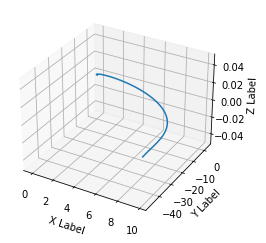

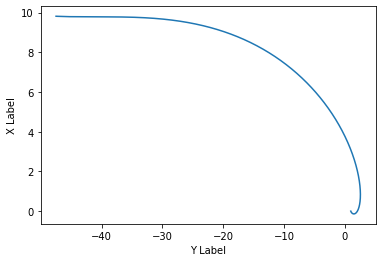

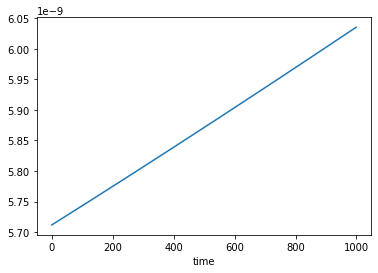

In [119]:
# plot trajectory
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# convert u.value to 3d
u = u.value.reshape((numSteps,3))

x_trajectory = [x_0[0][0]]
y_trajectory = [x_0[1][0]]
z_trajectory = [x_0[2][0]]

x_i = x_0
# get x,y,z values for plotting
for i in range(1,numSteps+1):
    #x_i = moveOneStep(x_i, u.value, timeStep, i)
    x_i = move(x_0, u, i, timeStep)
    # get first three elements of x_i
    x_trajectory.append(x_i[0][0])
    y_trajectory.append(x_i[1][0])
    z_trajectory.append(x_i[2][0])

print("Final Position")
print((x_trajectory[-1], y_trajectory[-1], z_trajectory[-1]))
# print sizes

# plot trajectory
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(x_trajectory, y_trajectory, z_trajectory)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(y_trajectory, x_trajectory)
ax.set_xlabel('Y Label')
ax.set_ylabel('X Label')

# plot usage of thrust magnitude at each time step
thrust = [ math.sqrt(u[i][0]**2 + u[i][1]**2 + u[i][2]**2) for i in range(numSteps)]
#print(thrust)
plt.figure()
plt.plot(thrust)
plt.xlabel('time')

plt.show()